In [1]:
%load_ext autoreload
%autoreload 2
    
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# from typing import Text

In [2]:
%cd /home/dvc-2-iris-demo

/home/dvc-2-iris-demo


# Load dataset

### Create functions 

```python
def get_dataset() -> pd.DataFrame:
    """Read dataset into pandas.DataFrame
    
    Returns:
        pandas.DataFrame
    """
    
    data = load_iris(as_frame=True)
    
    dataset = data.frame
    dataset.columns = [colname.strip(' (cm)').replace(' ', '_') for colname in dataset.columns.tolist()]

    return dataset


def get_target_names() -> List:
    return load_iris(as_frame=True).target_names.tolist()

```

### Move into .py modules

- move `get_dataset()` into src/data/dataset.py 

### Import functions

In [8]:
from src.data.dataset import get_dataset,  get_target_names

dataset = get_dataset()

print(dataset.shape)
dataset.head()

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
# feature names
feature_names = dataset.columns.tolist()[:4]
feature_names 

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [12]:
# iris species
species = get_target_names()
species

['setosa', 'versicolor', 'virginica']

# Features engineering

### Create functions 

```python
def extract_features(df: pd.DataFrame) -> pd.DataFrame:
    """Extract features.

    Args:
        df {pandas.DataFrame}: dataset

    Returns:
        pandas.DataFrame: updated dataset with new features
    """

    dataset = df.copy()
    dataset['sepal_length_to_sepal_width'] = dataset['sepal_length'] / dataset['sepal_width']
    dataset['petal_length_to_petal_width'] = dataset['petal_length'] / dataset['petal_width']


    dataset = dataset[[
        'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
        'sepal_length_to_sepal_width', 'petal_length_to_petal_width',

        'target'
    ]]

    return dataset
```

### Move into .py modules

- move `extract_features()` into src/features/features.py 

In [15]:
from src.features.features import extract_features

dataset = extract_features(dataset)
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,sepal_length_to_sepal_width,petal_length_to_petal_width,target
0,5.1,3.5,1.4,0.2,1.457143,7.0,0
1,4.9,3.0,1.4,0.2,1.633333,7.0,0
2,4.7,3.2,1.3,0.2,1.468750,6.5,0
3,4.6,3.1,1.5,0.2,1.483871,7.5,0
4,5.0,3.6,1.4,0.2,1.388889,7.0,0


# Split dataset

In [17]:
from sklearn.model_selection import train_test_split

test_size = 0.2
random_state = 42

In [18]:
train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=42)
train_dataset.shape, test_dataset.shape

((120, 7), (30, 7))

# Train

### Create functions 

```python
def train_lr(df: pd.DataFrame, target_column: Text) -> LogisticRegression:
    
    # Get X and Y
    y_train = df.loc[:, target_column].values.astype('int32')
    X_train = df.drop(target_column, axis=1).values.astype('float32')

    # Create an instance of Logistic Regression Classifier CV and fit the data

    logreg = LogisticRegression(C=0.001, solver='lbfgs', multi_class='multinomial', max_iter=100)
    logreg.fit(X_train, y_train)

    return logreg

```

### Move into .py modules

- move `train_lr()` into src/train/train.py 

In [20]:
from src.train.train import train_lr

model = train_lr(
    df = dataset,
    target_column = 'target'
)

In [21]:
model

LogisticRegression(C=0.001, multi_class='multinomial')


# Evaluate


### Create functions 


```python

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def evaluate(df: pd.DataFrame, target_column: Text, clf: BaseEstimator) -> Tuple[float, np.ndarray]:
    """Evaluate classifier on dataset
    
    Args:
        df {pandas.DataFrame}: dataset
        target_column {Text}: target column name
        clf {sklearn.base.BaseEstimator}: classifier (trained model)
        
    Returns:
        Tuple[float, numpy.ndarray]: tuple of score and confusion matrix
        
    """

    # Get X and Y
    y_test = df.loc[:, target_column].values.astype('int32')
    X_test = df.drop(target_column, axis=1).values.astype('float32')
    prediction = clf.predict(X_test)
    f1 = f1_score(y_true=y_test, y_pred=prediction, average='macro')
    cm = confusion_matrix(prediction, y_test)

    return f1, cm

```


### Move into .py modules

- move `evaluate()` to src/evaluate/evaluate.py 
- move `plot_confusion_matrix()` to src/report/visualize.py 

In [32]:
from src.evaluate.evaluate import evaluate
from src.report.visualize import plot_confusion_matrix


f1, cm = evaluate(
    df=dataset,
    target_column='target',
    clf=model
)

print(f1)
print(cm)

0.7889143647414202
[[50  0  0]
 [ 0 21  0]
 [ 0 29 50]]


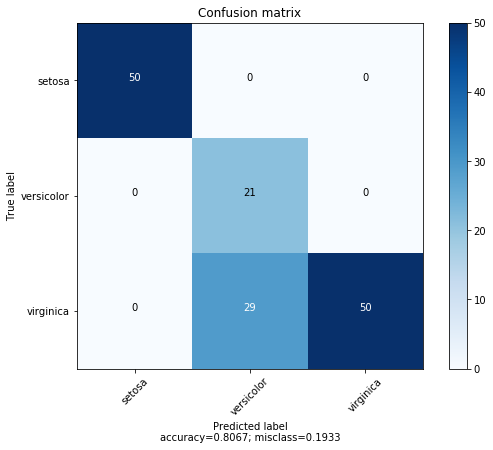

In [33]:
plot_confusion_matrix(cm, species, normalize=False)